In [18]:
using Distributions
using Turing
using PyPlot
using StatsPlots

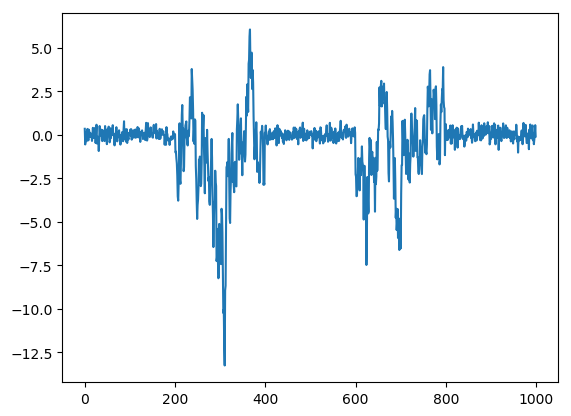

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000642F42B0>

In [19]:
# Generate data
μ_θ = 0.9    # AR coef mean
σ_θ = 0.2    # AR coef std
σ_s = 1      # AR innovation std

σ_n = 0.3    # noise std

x = Float64[]
for k = 1:1000
    
    if k % 400 > 200
        # AR
        θ = rand(Normal(μ_θ, σ_θ))
        push!(x, rand(Normal(x[k-1]*θ, σ_s)))
    else
        push!(x, 0.0)
    end
end

# add noise
x = x + rand(Normal(0,σ_n), length(x))

plt.plot(x)

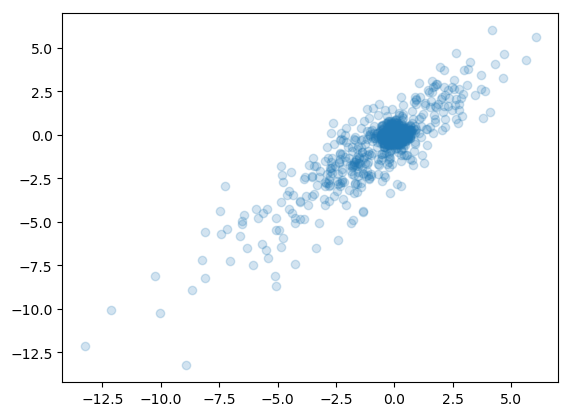

PyObject <matplotlib.collections.PathCollection object at 0x000000006434F978>

In [20]:
# plot against previous variable
plt.scatter(x[2:end], x[1:end-1], alpha=0.2)

# line with AR slope and dot in middle for noise

In [95]:
@model AR1(x) = begin

    # sample segments
    nr_segments = 20
    π1 ~ Beta(1,1)
    z = Vector(undef, nr_segments)
    z[1] ~ Categorical([π1, 1-π1])
    T = Vector{Vector}(undef, 2)
    T[1] ~ Dirichlet([1,1])
    T[2] ~ Dirichlet([1,1])
    for zn = 2:nr_segments
        z[zn] ~ Categorical(vec(T[z[zn-1]]))
    end
    
    # prior distributions
    μθ ~ Normal()
    σθ ~ InverseGamma()
    σs ~ InverseGamma()
    σn ~ InverseGamma()
    θ ~ Normal(μθ, σθ)
    
    # samples
    h = Vector(undef, length(x))
    h[1] ~ Normal()
    for n = 2:length(x)
        
        if z[Int(ceil(n*nr_segments/length(x)))] == 1
            h[n] ~ Normal(θ*x[n-1], σs)
        else
            h[n] = 0
        end
        
        x[n] ~ Normal(h[n], σn)

    end

end

##AR1#2519 (generic function with 2 methods)

In [96]:
turnprogress(true)

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 50
ϵ = 0.02
τ = 20

#sampler = HMC(ϵ, τ)
#sampler = NUTS(200, 0.6)
sampler = Gibbs(PG(500, :z, :T), HMC(ϵ, τ, :μθ, :σs, :σn, :σθ, :π1))


# Start sampling.
chain = sample(AR1(x), sampler, iterations);

┌ Info: [Turing]: progress logging is enabled globally
└ @ Turing C:\Users\s151781\.julia\packages\Turing\cReBm\src\Turing.jl:22


MethodError: MethodError: no method matching Normal(::Normal{Float64}, ::Float64)
Closest candidates are:
  Normal(!Matched::T, ::T; check_args) where T<:Real at C:\Users\s151781\.julia\packages\Distributions\dTXqn\src\univariate\continuous\normal.jl:37
  Normal(!Matched::Real, ::Real) at C:\Users\s151781\.julia\packages\Distributions\dTXqn\src\univariate\continuous\normal.jl:42

In [94]:
describe(chain)

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se     mcse     ess   r_hat
  ──────────  ──────  ──────  ────────  ───────  ──────  ──────
     T[1][1]  0.8239  0.1464    0.0207  missing  6.0381  1.0954
     T[1][2]  0.1761  0.1464    0.0207  missing  6.0381  1.0954
     T[2][1]  0.1775  0.0417    0.0059  missing  6.0381  1.0954
     T[2][2]  0.8225  0.0417    0.0059  missing  6.0381  1.0954
        z[1]  2.0000  0.0000    0.0000  missing     NaN     NaN
        z[2]  2.0000  0.0000    0.0000  missing     NaN     NaN
        z[3]  1.9000  0.3030    0.0429  missing  6.0381  1.0954
        z[4]  2.0000  0.0000    0.0000  missing     NaN     NaN
        z[5]  2.0000  0.0000    0.0000  missing     NaN     NaN
        z[6]  1.0000  0.0000    0.0000  missing     NaN     NaN
        z[7]  1.1000  0.3030    0.0429  missing  6.0381  1.0954
        z[8]  1.0000  0.0000    0.0000  missing     NaN     NaN
        z[9]  2.0000  0.0000    0.0000  missing   